In [170]:
from __future__ import print_function
import argparse
import numpy as np
import os
import shutil
import time
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pickle
from benedict import BeneDict
import copy
import seaborn as sns
from scipy.stats.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import pandas as pd
palette = sns.color_palette('muted')
plt.style.use('seaborn-muted')
plt.style.use('seaborn-talk')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
# Custom code
import utils as U
from generate_graph_structure import (
    create_adjacency_matrix, 
    flatten_correlation,
    granger_causality,
    behavioral_prediction_correlation_wrapper)
from dataloading import read_from_files, filter_data, normalize_by_behavior_report_type

In [47]:
savenames = [
             'BAYLORGC4_2018_03_20.mat',
             'BAYLORGC4_2018_03_21.mat',
             'BAYLORGC4_2018_03_22.mat',
             'BAYLORGC4_2018_03_23.mat',
             'BAYLORGC4_2018_03_25.mat',
             'BAYLORGC12_2018_04_03.mat',
             'BAYLORGC12_2018_04_04.mat',
             'BAYLORGC12_2018_04_05.mat',
             'BAYLORGC12_2018_04_06.mat',
#              'BAYLORGC13_2018_04_23.mat',
#              'BAYLORGC13_2018_04_24.mat',
#              'BAYLORGC13_2018_04_25.mat',
#              'BAYLORGC15_2018_05_07.mat',
#              'BAYLORGC15_2018_05_08.mat',
#              'BAYLORGC15_2018_05_09.mat',
#              'BAYLORGC15_2018_05_10.mat',
#              'BAYLORGC15_2018_05_11.mat',
#              'BAYLORGC17_2018_06_08.mat',
#              'BAYLORGC17_2018_06_11.mat',
#              'BAYLORGC18_2018_05_31.mat',
#              'BAYLORGC19_2018_06_20.mat',
#              'BAYLORGC19_2018_06_21.mat',
#              'BAYLORGC19_2018_06_22.mat'
            ]
# !!!!! Change here to generate graphs for different sessions
# all_file_to_read = [savenames[0]]
all_file_to_read = savenames
print('Reading files {}'.format(', '.join(all_file_to_read)))
all_data = read_from_files(all_file_to_read)

Reading files BAYLORGC4_2018_03_20.mat, BAYLORGC4_2018_03_21.mat, BAYLORGC4_2018_03_22.mat, BAYLORGC4_2018_03_23.mat, BAYLORGC4_2018_03_25.mat, BAYLORGC12_2018_04_03.mat, BAYLORGC12_2018_04_04.mat, BAYLORGC12_2018_04_05.mat, BAYLORGC12_2018_04_06.mat


In [70]:
# !!!!! Change here to generate graphs for different perturbation conditions

# The type of perturbation enforced
## 0: no 
## 1: perturbation of left
## 2: perturbation of right
## 3: perturbation of both
perturbation_type = 0 # or 1, 2, or 3
perturbation_type_names = ['No Perturbation', 'Left Perturbation', 'Right Perturbation', 'Bilateral Perturbation']
perturbation_type_name = perturbation_type_names[perturbation_type]

# Only look at success trials when True
# When there is bilarteral perturbation, the mice cannot act correctly, so we need to look at unsuccessful trials
enforce_task_success = (perturbation_type != 3)
# When there is no perturbation
if perturbation_type == 0:
    time_window = (22,37)
else:
# when there are perturbations, we use neural signals after the perturbations have ended
    time_window = (31,37)

In [71]:
## Filter all the data depending on what we want
all_data_filtered = [filter_data(data,
                                 perturbation_type=perturbation_type,
                                 enforce_task_success=enforce_task_success,
                                 time_window=time_window) for data in all_data]



In [72]:
di = all_data_filtered[2]
print(di.train_rates.shape)
train_rates_mean = np.mean(di.train_rates, axis=0)

(206, 15, 84)


(array([4., 1., 3., 1., 0., 2., 0., 2., 1., 1.]),
 array([0.9759844 , 0.98200495, 0.98802549, 0.99404603, 1.00006658,
        1.00608712, 1.01210767, 1.01812821, 1.02414875, 1.0301693 ,
        1.03618984]),
 <a list of 10 Patch objects>)

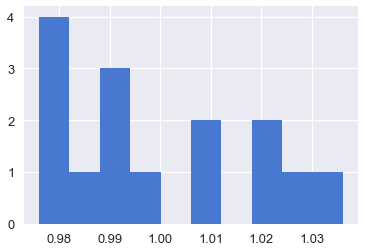

In [73]:
# mean taken over neurons, mean at various time steps
plt.hist(np.mean(train_rates_mean, axis=1) / np.mean(train_rates_mean))

(array([38., 11., 17.,  4.,  1.,  5.,  3.,  4.,  0.,  1.]),
 array([ 0.5736246 ,  2.60703883,  4.64045307,  6.67386731,  8.70728155,
        10.74069579, 12.77411003, 14.80752427, 16.84093851, 18.87435275,
        20.90776699]),
 <a list of 10 Patch objects>)

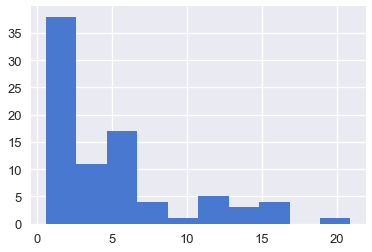

In [74]:
# mean taken over neurons, mean at various neurons
plt.hist(np.mean(train_rates_mean, axis=0))

In [76]:
def coin(p=0.5):
    return np.random.uniform() <= p

In [157]:
# Simulation one, 
# Neuron a, neuron b
# a has probability pa of activating byitself
# b has probability pb of activating byitself
# a's activation at T, w has probability q of activating b at T + 1, w.
# Each timestep we have W times to test for stimulation
# T time steps
# N simulations

# N = 100
# T = 15
# W = 20
# pa = 0.3
# pb = 0.3
# q = 0.7

def simulation_ab(N, T, W, pa, pb, q):
    train_rates = np.zeros([N, T, 2])
    for n in range(N):
        a_cache = [False for w in range(W)]
        for t in range(T):
            for w in range(W):
                if coin(pb) or (a_cache[w] and coin(q)):
                    train_rates[n, t, 1] += 1
                if coin(pa):
                    train_rates[n, t, 0] += 1
                    a_cache[w] = True
                else:
                    a_cache[w] = False
    return train_rates

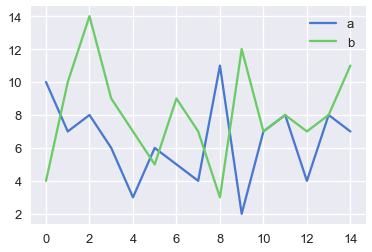

In [158]:
train_rates.shape

plt.plot(train_rates[0, :, 0], label='a')
plt.plot(train_rates[0, :, 1], label='b')
plt.legend()
plt.show()

In [189]:
# N = 100
T = 15
W = 20
n_trials = 100
# n_trials = 2
all_results = []
for N in [3, 10, 30, 100]:
    for pa in [0.1, 0.3, 0.5]:
        if pa != 0.3:
            continue
        for pb in [0.1, 0.3, 0.5]:
            if pb != 0.3:
                continue
            for q in [0.3, 0.5, 0.7]:
                if q != 0.3:
                    continue
                print(N, pa, pb, q)
                di = {
                    'N': N,
                    'pa': pa,
                    'pb': pb,
                    'q': q,
                    'trials': n_trials,
                }
                grangers = []
                corrs = []
                for trial in range(n_trials):
                    train_rates = simulation_ab(N, T, W, pa, pb, q)
                    grangers.append(granger_causality(train_rates[:, :, 0], train_rates[:, :, 1]))
                    corrs.append(flatten_correlation(train_rates[:, :, 0], train_rates[:, :, 1]))
                di['gr_mean'] = np.mean(grangers)
                di['gr_std'] = np.std(grangers)
                di['cr_mean'] = np.mean(corrs)
                di['cr_std'] = np.std(corrs)
                all_results.append(di)

3 0.3 0.3 0.3
10 0.3 0.3 0.3
30 0.3 0.3 0.3
100 0.3 0.3 0.3


[{'N': 3, 'pa': 0.3, 'pb': 0.3, 'q': 0.3, 'trials': 100, 'gr_mean': 0.7367107392791304, 'gr_std': 0.26081099786238776, 'cr_mean': 0.12758487283380154, 'cr_std': 0.08584243248809928}, {'N': 10, 'pa': 0.3, 'pb': 0.3, 'q': 0.3, 'trials': 100, 'gr_mean': 0.8894221205733467, 'gr_std': 0.1830946469164682, 'cr_mean': 0.0685224617624291, 'cr_std': 0.0516174612923359}, {'N': 30, 'pa': 0.3, 'pb': 0.3, 'q': 0.3, 'trials': 100, 'gr_mean': 0.9961199936582151, 'gr_std': 0.01868179550678488, 'cr_mean': 0.03528653471005382, 'cr_std': 0.027237364881024247}, {'N': 100, 'pa': 0.3, 'pb': 0.3, 'q': 0.3, 'trials': 100, 'gr_mean': 0.9999999788976345, 'gr_std': 1.8940883408795368e-07, 'cr_mean': 0.019805127889099283, 'cr_std': 0.01626790347879952}]


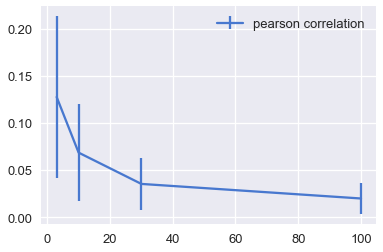

In [191]:
print(all_results)
df = pd.DataFrame.from_records(all_results)
plt.errorbar(df.N, df.cr_mean, df.cr_std, label='pearson correlation')
# plt.errorbar(df.N, df.gr_mean, df.gr_std, label='granger correlation')
plt.legend()

In [156]:
def plot_node_deg(mat, neuron_locations, method_name, perturbation_type_name, session_name, eps=0.05):
    in_deg = np.sum(mat, axis=0)
    out_deg = np.sum(mat, axis=1)
    degs = np.concatenate([in_deg, out_deg])
    value_range = np.linspace(np.min(degs) - eps, np.max(degs) + eps, 10)
    symmetric =  np.allclose(in_deg, out_deg)
    in_count = U.binned(in_deg, value_range)
    out_count = U.binned(out_deg, value_range)
    x = (value_range[:-1] + value_range[1:]) / 2
    f = plt.figure()
    if symmetric:
        plt.plot(x, in_count, label='Degree', color=palette[0])
    else:
        plt.plot(x, in_count, label='In Degree', color=palette[1])
        plt.plot(x, out_count, label='Out Degree', color=palette[2])
    plt.legend()
    plt.xlabel('Node Deg')
    plt.ylabel('Count')
    plt.title('Node Degree Distribution: {} Network\n ( {} Trials)'.format(method_name, perturbation_type_name), fontsize=12)
    plt.tight_layout()
    # TODO: add session name
#     f.savefig('node-deg-figures/{}-{}.pdf'.format(method_name, perturbation_type_name))
    plt.show()

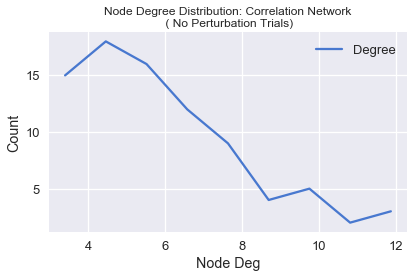

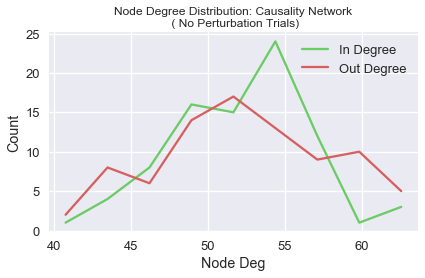

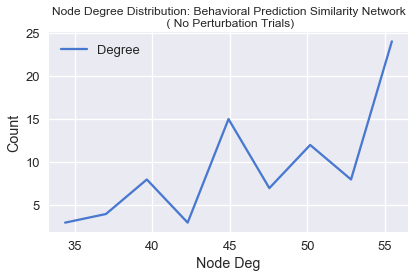

In [45]:

# mat = mat_correlation
# neuron_locations = a.neuron_locations
# method_name = 'Correlation'

for i in range(len(mats)):
    mat = mats[i]
    method_name = method_names[i]
    plot_node_deg(mat, neuron_locations, method_name, perturbation_type_name, session_name)

In [194]:
di = all_data[0]

In [197]:
di["neuron_locations"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])